In [457]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [458]:
# Load raw cell image file paths only (do not load images)
raw_cells_dir = "../../data/digits/manual/raw/"
raw_cell_image_paths = []

# The images are stored directly in the raw directory, not in session subdirectories
for fname in os.listdir(raw_cells_dir):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(raw_cells_dir, fname)
        raw_cell_image_paths.append(img_path)

print(f"Found {len(raw_cell_image_paths)} raw cell image files")


Found 1134 raw cell image files


In [459]:
# Load the actual raw cell images
raw_cell_images = []

for img_path in raw_cell_image_paths:
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is not None:
        raw_cell_images.append(img)
    else:
        print(f"Failed to load image: {img_path}")

print(f"Loaded {len(raw_cell_images)} raw cell images")


Loaded 1134 raw cell images


In [460]:
def remove_grid_borders(cell_image, debug=False):
    """
    Remove grid borders from a cell image by iteratively clearing black pixels from the edges,
    and return the cleaned image (digit only, background white).
    Steps:
    1. Darken the image by 30%.
    2. Blur the image.
    3. Binarize the image (background white, digit black) using Otsu's thresholding.
    4. For each edge, clear strips as long as the black percent is above threshold.
    5. Set those strips to white in the original image.
    6. Binarize the final cleaned image and return it (digit black, background white).
    """

    blur_ksize = 3
    max_val = 255
    black_percent_threshold = 0.35
    edge_strip_width = 3
    max_strips = 35

    img = cell_image.copy()
    # img = (img.astype(np.float32) * 0.7).clip(0, 255).astype(np.uint8)
    img_blur = cv.GaussianBlur(img, (17, 17), 0)
    _, img_bin = cv.threshold(img_blur, 0, max_val, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    img_bin = cv.bitwise_not(img_bin)

    h, w = img_bin.shape
    cleaned = cell_image.copy()

    for side in ['top', 'bottom', 'left', 'right']:
        for i in range(max_strips):
            if side == 'top':
                y1, y2 = i * edge_strip_width, min((i + 1) * edge_strip_width, h)
                x1, x2 = 0, w
            elif side == 'bottom':
                y1, y2 = h - (i + 1) * edge_strip_width, h - i * edge_strip_width
                y1 = max(y1, 0)
                x1, x2 = 0, w
            elif side == 'left':
                x1, x2 = i * edge_strip_width, min((i + 1) * edge_strip_width, w)
                y1, y2 = 0, h
            elif side == 'right':
                x1, x2 = w - (i + 1) * edge_strip_width, w - i * edge_strip_width
                x1 = max(x1, 0)
                y1, y2 = 0, h

            roi = img_bin[y1:y2, x1:x2]
            total = roi.size
            black = np.count_nonzero(roi == 0)
            black_percent = black / total if total > 0 else 0

            if black_percent > black_percent_threshold:
                cleaned[y1:y2, x1:x2] = 255
            else:
                break



    if debug:
        import matplotlib.pyplot as plt
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        axs[0].imshow(cell_image, cmap='gray')
        axs[0].set_title('Original')
        axs[1].imshow(img_blur, cmap='gray')
        axs[1].set_title('Blurred')
        axs[2].imshow(img_bin, cmap='gray')
        axs[2].set_title('Binarized')
        axs[3].imshow(cleaned, cmap='gray')
        axs[3].set_title('Cleaned (White Strips)')
        for ax in axs:
            ax.axis('off')
        plt.show()

    return cleaned





In [461]:
def find_digit_in_cell(cell_image):
    """
    Finds the bounding rectangle of the largest contour (digit) in the cell image,
    crops to that region, and resizes back to the original cell_image size.
    """
    # Clean the image: binarize and dilate to connect digit parts
    _, cleaned = cv.threshold(cell_image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    dilation = cv.dilate(cleaned, kernel, iterations=1)
    # Find contours
    contours, _ = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(largest)
        # Crop to bounding box
        cropped = cell_image[y:y+h, x:x+w]
        # Resize back to original size
        resized = cv.resize(cropped, (cell_image.shape[1], cell_image.shape[0]), interpolation=cv.INTER_LINEAR)
        return resized
    else:
        # If no contour found, return the original image
        return cell_image


In [462]:
def process_cell(cell_image, debug=False):
    """
    Process cell image to remove grid borders, clean up the image, and sharpen the digit
    """
    no_border = remove_grid_borders(cell_image, debug=False)
    filtered_digit = find_digit_in_cell(no_border)

    binary = cv.GaussianBlur(filtered_digit, (3, 3), 0)
    thresh = cv.adaptiveThreshold(binary, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                              cv.THRESH_BINARY, 11, 2)

    # Add a decent blur to the thresholded image to help smooth digit edges
    thresh = cv.GaussianBlur(thresh, (7, 7), 0)
    kernel = np.ones((3,3), np.uint8)
    binary = cv.dilate(thresh, kernel, iterations=1)
    thresh = cv.GaussianBlur(binary, (7, 7), 0)
    # # Simply sharpen digit
    # Invert colors
    binary = cv.bitwise_not(binary)
    # Erode the image
    kernel = np.ones((7,7), np.uint8)
    binary = cv.dilate(binary, kernel, iterations=1)
    kernel = np.ones((3,3), np.uint8)
    binary = cv.erode(binary, kernel, iterations=1)
    binary = cv.adaptiveThreshold(binary, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                              cv.THRESH_BINARY, 11, 2)

    filtered_digit = binary

    return filtered_digit



In [463]:
# Simple function to test process_cell on a specific image
def test_process_cell(idx, debug=True):
    """Test process_cell function on a specific image, showing intermediate output."""
    if idx < len(raw_cell_images):
        raw_img = raw_cell_images[idx]
        print(f"Testing image {idx}")
        print(f"Raw image shape: {raw_img.shape}")
        print(f"Raw image range: {raw_img.min()} to {raw_img.max()}")

        # Show output of find_digit_in_cell
        digit_img = find_digit_in_cell(raw_img)
        
        # Process the image
        processed_img = process_cell(raw_img, debug=debug)
        
        # Display: raw image, digit image, processed image
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Raw image
        axes[0].imshow(raw_img, cmap='gray')
        axes[0].set_title(f'Raw Image {idx}\nSize: {raw_img.shape}')
        axes[0].axis('off')
        
        # Output of find_digit_in_cell
        axes[1].imshow(digit_img, cmap='gray')
        axes[1].set_title('find_digit_in_cell Output')
        axes[1].axis('off')
        
        # Processed image
        axes[2].imshow(processed_img, cmap='gray')
        axes[2].set_title(f'Processed Image {idx}\nSize: {processed_img.shape}')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Processed image range: {processed_img.min()} to {processed_img.max()}")
        
        return processed_img
    else:
        print(f"Index {idx} out of range. Available images: 0-{len(raw_cell_images)-1}")
        return None


In [464]:
# Test the process_cell function
print(f"Loaded {len(raw_cell_images)} raw cell images")
print("Use test_process_cell(idx) to test on a specific image")
print("Example: test_process_cell(0, debug=True)")


Loaded 1134 raw cell images
Use test_process_cell(idx) to test on a specific image
Example: test_process_cell(0, debug=True)


Testing image 130
Raw image shape: (50, 50)
Raw image range: 71 to 153


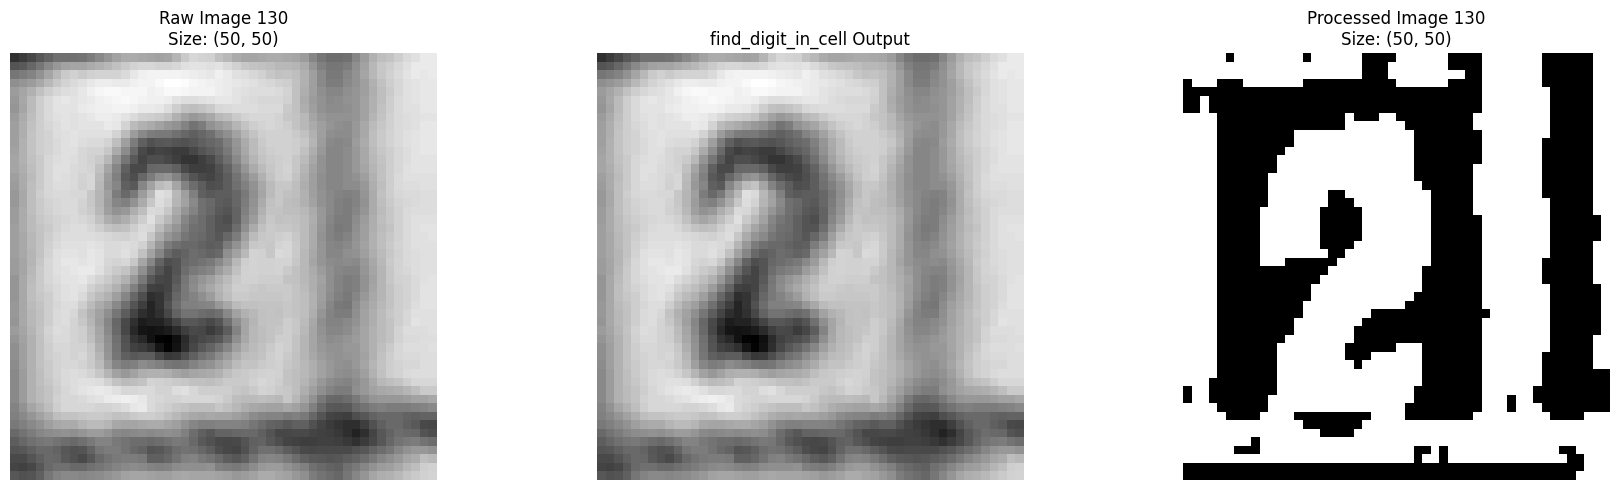

Processed image range: 0 to 255


array([[255, 255, 255, ...,   0, 255, 255],
       [255, 255, 255, ...,   0, 255, 255],
       [255, 255, 255, ...,   0, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], shape=(50, 50), dtype=uint8)

In [465]:
test_process_cell(130, debug=True)


Testing image 110
Raw image shape: (50, 50)
Raw image range: 69 to 227


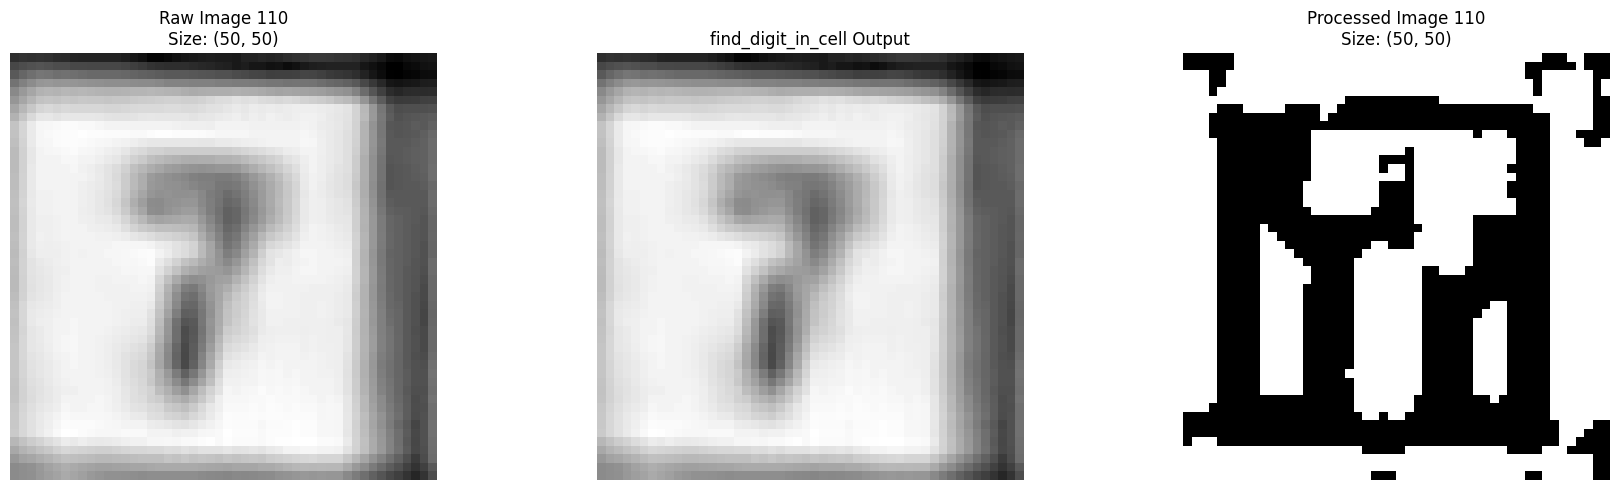

Processed image range: 0 to 255


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 255, ..., 255,   0,   0],
       ...,
       [255, 255, 255, ..., 255,   0,   0],
       [255, 255, 255, ..., 255,   0,   0],
       [255, 255, 255, ..., 255,   0,   0]], shape=(50, 50), dtype=uint8)

In [466]:
test_process_cell(110, debug=True)